## Geometric Brownian motion (GBM) 삼성전자 주가데이터

In [ ]:
# 1. asfreq('B') — 빈 날짜 생성
# asfreq('B')는 "Business Day Frequency", 즉 영업일 단위로 리샘플링(resample) 하는 함수입니다.
# 원래 데이터가 특정 날짜(예: 주말 제외)만 존재할 경우, 이 명령은 모든 영업일을 포함한 시계열로 바꿉니다.
# 하지만 기존에 존재하지 않던 날짜들은 NaN으로 채워지게 됩니다.

In [ ]:
# 2. fillna(method='ffill') — 결측값 보간 (앞 값으로 채우기)
# fillna(method='ffill')는 결측값(NaN)을 바로 앞에 있는 값으로 채워 넣습니다.
# 이를 통해 데이터의 연속성 유지 및 모델 학습 시 오류 방지가 가능합니다.

C:\Users\JYB\AppData\Local\Temp\ipykernel_2856\1828475742.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill') #  결측값 없이 연속적인 "영업일 단위" 데이터


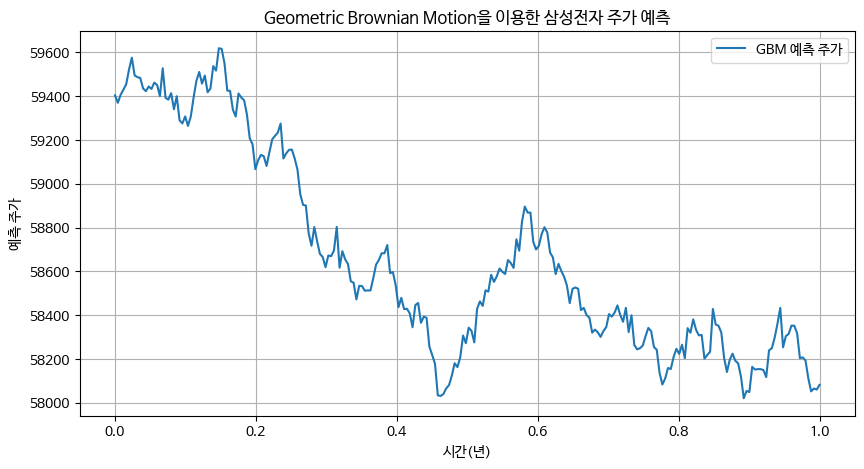

In [4]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 삼성전자 주가 데이터
df = stock.get_market_ohlcv_by_date("2020-01-01", "2025-06-20", "005930")
df = df[['종가']].copy()
df.index = pd.to_datetime(df.index)
df = df.asfreq('B').fillna(method='ffill') #  결측값 없이 연속적인 "영업일 단위" 데이터

# 로그수익률 및 GBM 시뮬레이션
df['log_return'] = np.log(df['종가'] / df['종가'].shift(1)) # shift(1)은 하루 전 종가를 의미하며, np.log()는 자연로그를 계산
mu, sigma = df['log_return'].mean(), df['log_return'].std() #mu: 일간 로그수익률의 평균 → 수익의 기대값, sigma: 일간 로그수익률의 표준편차 → 변동성(Volatility)

# T = 1: 1년 (기간) 동안의 시뮬레이션
# N = 252: 영업일 기준 일 수 (주식 시장의 평균 연간 거래일)
# dt = 1/252: 1일 단위의 시간 간격
# S0: 현재 시점의 종가 (마지막 종가)
# 시뮬레이션의 시작 주가로 사용

# 시간 벡터 생성
# t = np.linspace(0, T, N)
# t: 0부터 1년까지 균등 간격의 시간 배열
# 길이 N → 시뮬레이션 주가 시계열의 시간 축

T, N, dt = 1, 252, 1/252
S0 = df['종가'].iloc[-1]
t = np.linspace(0, T, N)

# 브라운 운동 경로 생성
# W = np.cumsum(np.random.standard_normal(N)) * np.sqrt(dt)
# W: 브라운 운동 경로 (Wiener Process)
# 누적 표준 정규 분포 값을 √dt로 스케일링하여 생성
# np.random.standard_normal(N): 길이 N인 표준정규분포 샘플
#  GBM 방정식으로 주가 시뮬레이션
# S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

W = np.cumsum(np.random.standard_normal(N)) * np.sqrt(dt)
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(t, S, label='GBM 예측 주가')
plt.title('Geometric Brownian Motion을 이용한 삼성전자 주가 예측')
plt.xlabel('시간(년)')
plt.ylabel('예측 주가')
plt.grid(True)
plt.legend()
plt.show()


C:\Users\JYB\AppData\Local\Temp\ipykernel_14856\3047524820.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill')  # 평일 기준으로 재정렬하고 결측치는 직전 값으로 채움


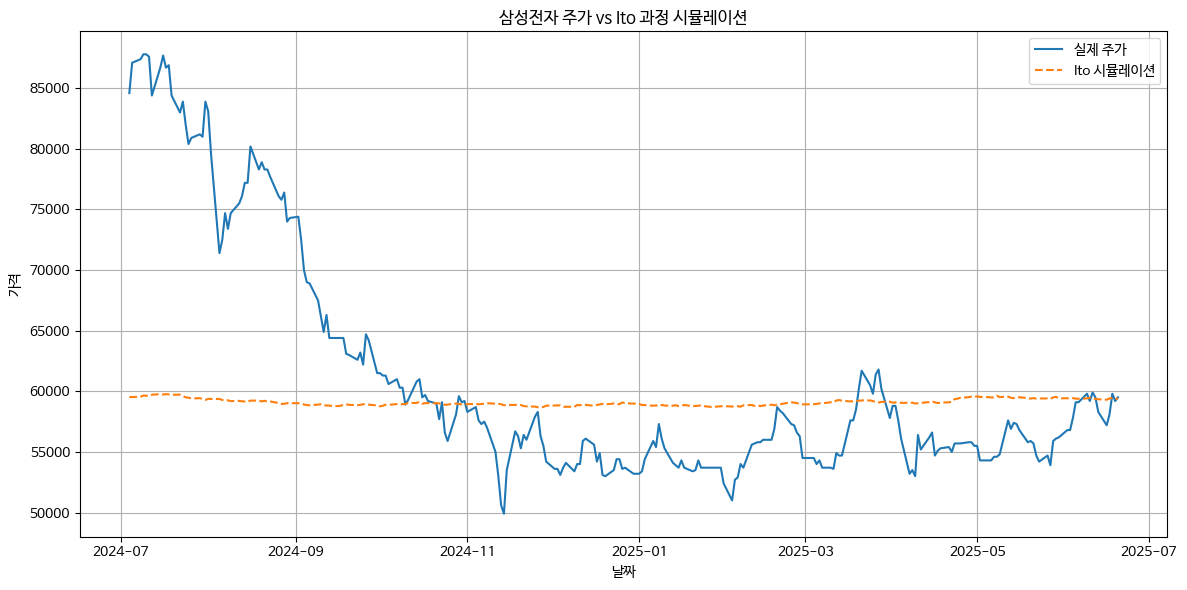

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

# 1. 삼성전자 주가 데이터 가져오기
df = stock.get_market_ohlcv_by_date("2022-01-01", "2025-06-20", "005930")
df = df[['종가']].copy()
df = df.asfreq('B').fillna(method='ffill')  # 평일 기준으로 재정렬하고 결측치는 직전 값으로 채움

# 2. 로그 수익률 계산
df['log_return'] = np.log(df['종가'] / df['종가'].shift(1))
df.dropna(inplace=True)

# 3. Ito 과정 매개변수 계산
mu = df['log_return'].mean()
sigma = df['log_return'].std()
S0 = df['종가'].iloc[-1]  # 현재 종가 기준

# 4. Ito 시뮬레이션 설정
T = 1  # 1년
N = 252  # 252 거래일
dt = T / N
t = np.linspace(0, T, N)
np.random.seed(42)  # 재현성 확보
W = np.cumsum(np.random.standard_normal(N)) * np.sqrt(dt)

# 5. Ito 과정에 따른 주가 시뮬레이션 (Geometric Brownian Motion)
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# 6. 실제 종가와 비교 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index[-N:], df['종가'].iloc[-N:], label='실제 주가')
plt.plot(df.index[-N:], S, label='Ito 시뮬레이션', linestyle='--')
plt.title("삼성전자 주가 vs Ito 과정 시뮬레이션")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Ito 주가 경로

C:\Users\JYB\AppData\Local\Temp\ipykernel_14856\4019856569.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill')


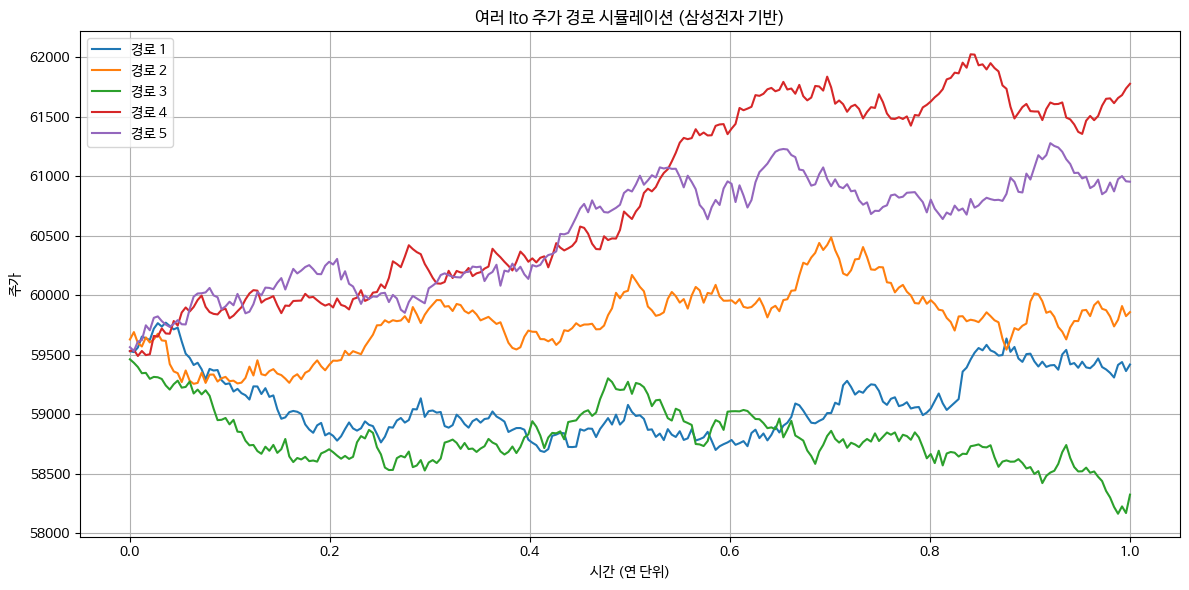

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

# 실제 데이터 가져오기
df = stock.get_market_ohlcv_by_date("2022-01-01", "2025-06-20", "005930")[['종가']].copy()
df = df.asfreq('B').fillna(method='ffill')

# 로그 수익률 계산
df['log_return'] = np.log(df['종가'] / df['종가'].shift(1))
df.dropna(inplace=True)

# Ito 파라미터 추정
mu = df['log_return'].mean()
sigma = df['log_return'].std()
S0 = df['종가'].iloc[-1]
T, N = 1, 252
dt = T / N
t = np.linspace(0, T, N)

# 시뮬레이션 수행
np.random.seed(42)
simulations = []
for _ in range(5):
    W = np.cumsum(np.random.standard_normal(N)) * np.sqrt(dt)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    simulations.append(S)

# 시각화
plt.figure(figsize=(12, 6))
for i, sim in enumerate(simulations):
    plt.plot(t, sim, label=f'경로 {i+1}')
plt.title('여러 Ito 주가 경로 시뮬레이션 (삼성전자 기반)')
plt.xlabel('시간 (연 단위)')
plt.ylabel('주가')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
삼성전자 + Wiener 과정 비교

C:\Users\JYB\AppData\Local\Temp\ipykernel_14856\242174455.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill')  # 영업일 기준 빈칸 보간


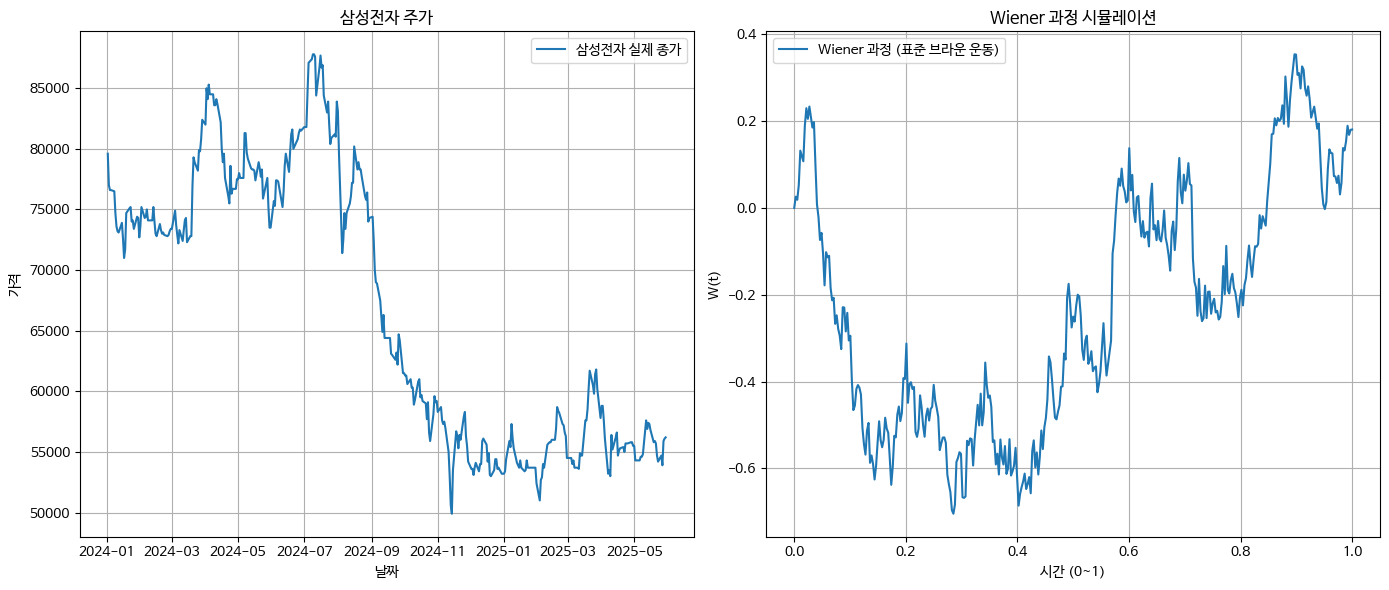

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

# 1. 삼성전자 주가 데이터 수집
df = stock.get_market_ohlcv_by_date("2024-01-01", "2025-05-31", "005930")[['종가']]
df = df.asfreq('B').fillna(method='ffill')  # 영업일 기준 빈칸 보간
prices = df['종가'].values
N = len(prices)
t = np.linspace(0, 1, N)

# 2. Wiener 과정 시뮬레이션
# 표준 정규분포를 따르는 난수를 N-1개 생성합니다.
# np.cumsum(...)난수들의 누적합을 구합니다.
# 누적합은 시점 𝑡까지의 Wiener 경로 𝑊(𝑡) 를 구성합니다.
# 전체적으로 의미하는 것: Wiener 과정은 누적된 정규분포 난수들의 합으로 구성됩니다.
np.random.seed(42)
W = np.zeros(N)
W[1:] = np.cumsum(np.random.normal(0, np.sqrt(1/N), N-1))

# 3. 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df.index, prices, label='삼성전자 실제 종가')
plt.title("삼성전자 주가")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, W, label='Wiener 과정 (표준 브라운 운동)')
plt.title("Wiener 과정 시뮬레이션")
plt.xlabel("시간 (0~1)")
plt.ylabel("W(t)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 왼쪽그래프 : 삼성전자 주가: 실제로 관측된 비정상적이고 복합적인 시계열.
# 오른쪽 그래프 : Wiener 과정: 순수 확률적 움직임을 나타내는 이상적 수학 모델.
# 두 그래프를 나란히 보면, 현실의 주가도 일정 부분 확률적 경향 (랜덤워크) 을 따르지만, 실제는 추세(trend) 나 계절성(seasonality) 도 존재할 수 있다는 점에서 차이가 있습니다.

# 오른쪽 그래프: Wiener 과정 (표준 브라운 운동)
# 그래프 구성
# X축: 시간 (0 ~ 1, 연 단위로 정규화됨)
# Y축: 표준 브라운 운동 
# 𝑊(𝑡) 값
# 해석
# 이 곡선은 무작위적인 누적 변화 경로를 시뮬레이션한 것입니다.
# 각 경로는 시간에 따라 오르내리는 순수한 랜덤워크를 따르며,
# 평균 변화가 0이고,변화의 크기(분산)는 시간에 비례하여 증가합니다.
# 현실 주가의 움직임이 랜덤워크 가설 (random walk hypothesis) 를 따를 수 있다는 점을 시각적으로 보여주는 데 유용합니다.